## Simple one-object dataset
Simple one object of random type and color in random position and orientation

In [1]:
import numpy as np

import sampling
from sampling import create_shape
from evaluation import evaluate_sample
from environment import grab_frame, reset_env

frame_size = (64, 64)
dataset_path = 'data/one_object_dataset_64'

def sample_func():
    bounds = (4.0, 4.0, 0.0)
    obj = sampling.ObjectOnTable.sample(origin=(0, 0, 1.0), max_bounds=bounds, max_rotation=2 * np.pi)
    
    predicates = sampling.get_on_table_relation(obj, bounds, add_positional=True)
    predicates.extend(sampling.get_false_predicates(predicates, 3))

    reset_env()
    create_shape(obj)
    frame = grab_frame(cam_pos=(0, -10, 12), cam_target=(0, -1, 0), light_dir=(-6, 1, 10), frame_size=frame_size)
    return frame, predicates
    

pybullet build time: May  8 2021 05:50:53


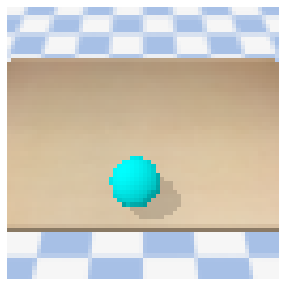

(cyan sphere on table) 1.0
(cyan sphere on_left_side_of table) 0.2731837457005719
(cyan sphere on_right_side_of table) 0.0
(cyan sphere on_far_side_of table) 0.0
(cyan sphere on_near_side_of table) 1.0
(cyan sphere in_center_of table) 0.0
(red sphere on table) 0.0
(cyan pyramid on_near_side_of table) 0.0
(blue sphere on_right_side_of table) 0.0


In [2]:
evaluate_sample(sample_func)

In [3]:
# Run only once!
from batching import create_dataset

create_dataset(dataset_path, num_batches=128, batch_size=128, sample_func=sample_func)
create_dataset(dataset_path + '_test', num_batches=8, batch_size=128, sample_func=sample_func)

Generating 128 * 128 = 16384 samples


100%|██████████| 128/128 [03:39<00:00,  1.71s/it]


Generating 8 * 128 = 1024 samples


100%|██████████| 8/8 [00:13<00:00,  1.71s/it]


In [37]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model

frame_inputs = layers.Input(shape=(*frame_size, 3))
x = layers.Rescaling(1.0 / 255.0)(frame_inputs)

for size in (8, 8, 16):
    x = layers.Conv2D(size, 3, padding="same", activation='relu')(x)
    x = layers.MaxPooling2D(2, padding="same")(x)        

x = layers.Flatten()(x)
conv_branch_outputs = layers.Dense(64, activation='relu')(x)

predicate_inputs = layers.Input(shape=(33,))
predicate_branch_outputs = layers.Dense(64, activation='relu')(predicate_inputs)

x = layers.concatenate([conv_branch_outputs, predicate_branch_outputs], axis=-1)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model([frame_inputs, predicate_inputs], outputs)
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 64, 64, 3)    0           input_5[0][0]                    
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 64, 64, 8)    224         rescaling_2[0][0]                
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 32, 32, 8)    0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [38]:
from batching import load_as_tf_dataset
training_set = load_as_tf_dataset(dataset_path).shuffle(128).batch(32)
testing_set = load_as_tf_dataset(dataset_path + "_test").batch(32)

In [45]:
%%time
progress = model.fit(training_set, validation_data=testing_set, epochs=5)

Epoch 1/5
4608/4608 [==============================] - 52s 11ms/step - loss: 0.0590 - accuracy: 0.9333 - val_loss: 0.0564 - val_accuracy: 0.9363
Epoch 2/5
4608/4608 [==============================] - 54s 12ms/step - loss: 0.0552 - accuracy: 0.9343 - val_loss: 0.0581 - val_accuracy: 0.9351
Epoch 3/5
4608/4608 [==============================] - 52s 11ms/step - loss: 0.0539 - accuracy: 0.9347 - val_loss: 0.0533 - val_accuracy: 0.9357
Epoch 4/5
4608/4608 [==============================] - 52s 11ms/step - loss: 0.0515 - accuracy: 0.9349 - val_loss: 0.0614 - val_accuracy: 0.9337
Epoch 5/5
4608/4608 [==============================] - 52s 11ms/step - loss: 0.0486 - accuracy: 0.9360 - val_loss: 0.0422 - val_accuracy: 0.9388
CPU times: user 4min 6s, sys: 26.4 s, total: 4min 33s
Wall time: 4min 21s


In [53]:
# model.save_weights("models/one_object_64input_8_8_16conv_64_128dense.h5")

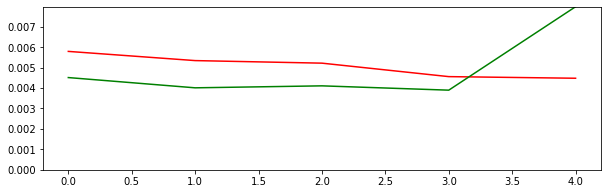

In [31]:
from utils import draw_progress
draw_progress(progress, fit_line=False)

In [10]:
probes = sampling.get_on_table_probes(add_positional=True)

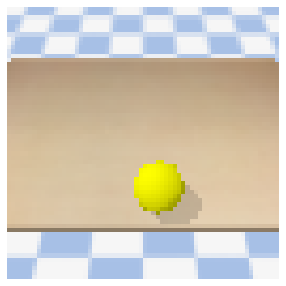

(yellow sphere on table) 1.0
(yellow sphere on_left_side_of table) 0.0
(yellow sphere on_right_side_of table) 0.6029768175182237
(yellow sphere on_far_side_of table) 0.0
(yellow sphere on_near_side_of table) 1.0
(yellow sphere in_center_of table) 0.0
(red sphere on_left_side_of table) 0.0
(cyan cube on_right_side_of table) 0.0
(red cube on table) 0.0
---
(yellow pyramid on table) 0.999241
(yellow pyramid on_near_side_of table) 0.9976878
(yellow sphere on_near_side_of table) 0.8259307
(yellow pyramid on_right_side_of table) 0.7718864
(yellow sphere on table) 0.43710533


In [52]:
evaluate_sample(sample_func, model, probes)